In [ ]:
"""
Author: Ryleigh J. Bruce
Date: May 30, 2024

Purpose: Using series of deep learning models to identify objects in a single image as well as a set of images.


Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the authors reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

## Introduction

This Jupyter Notebook provides a workflow for applying deep learning models to identify objects in individual images or image collections using pre-trained convolutional neural networks. It guides users through importing libraries, configuring parameters, preprocessing data, executing inference tasks and result visualization. The notebook is an accessible resource for computer vision applications.

## Critical Uses & Adaptability

### What the Notebooks Can Be Used For:

- **Dataset Exploration:**  
  The notebook allows users to load and visualize image datasets using the `load_images()` and `display_sample_images()` functions in the initial code blocks. This supports basic exploration and understanding of the dataset's structure and content.

- **Educational Purposes & Demonstrations:**  
  The notebook demonstrates the use of Python scripts and machine learning workflows for image analysis. It is structured to educate readers about the implementation of deep learning models, data preprocessing, and evaluation techniques, making it suitable for instructional settings or demonstrations.

### How the Notebook Can Be Adapted:

- **Integration with Spatial Design & Architectural Studies:**  
  The notebook can be adapted for spatial design and architectural studies by applying object detection to site analysis images. The modular functions allow for the extraction of spatial features relevant to architectural contexts.

- **Variables & Customization:**  
  Key variables, such as image size, model parameters, and augmentation settings, are defined at the beginning of the notebook. Users can adjust these variables in the configuration cell to tailor the workflow to specific project requirements.

- **Swapping Datasets:**  
  The dataset can be replaced by modifying the file path in the `load_images()` function in the first code block. This enables the notebook to be used with custom image datasets without altering the core workflow.

## Borealis Dataset Setup & API Configurations

The data is hosted in the University of Manitoba Dataverse (https://borealisdata.ca/dataverse/manitoba), a research data repository. The images used in this notebook were collected as part of the 'Understanding Animals' project at University of Manitoba Faculty of Architecture, online at [Wild Winnipeg](https://www.wildwinnipeg.org/) and [Teaching with Images](https://pressbooks.openedmb.ca/teachingwithimages/). These functions enable programmatic access to research datasets hosted on Borealis Data, with improved error handling and feedback. The functions handle dataset information retrieval, file downloading, and archive extraction with detailed status reporting.

In [ ]:
import requests
import zipfile
import os
import glob

# Borealis API configuration
BOREALIS_SERVER = "https://borealisdata.ca"

def get_public_dataset_info(persistent_id):
    """
    Get information about a public dataset
    """
    url = f"{BOREALIS_SERVER}/api/datasets/:persistentId/"
    params = {"persistentId": persistent_id}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        dataset_info = response.json()
    else:
        print(f"Cannot access dataset: {response.status_code}")
        return None

    # Get a list of files in a public dataset
    files_list = dataset_info['data']['latestVersion']['files']
    file_info_list = []

    for file_info in files_list:
        file_id = file_info['dataFile']['id']
        filename = file_info['dataFile']['filename']
        file_info_list.append({"file_id": file_id, "filename": filename})

    return file_info_list

def download_public_file(file_id, save_path="./"):
    """
    Download a specific public file from a dataset by its file ID
    """
    url = f"{BOREALIS_SERVER}/api/access/datafile/{file_id}"
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        filename = None
        if "Content-Disposition" in response.headers:
            cd = response.headers["Content-Disposition"]
            if "filename=" in cd:
                filename = cd.split("filename=")[1].strip('"')

        if not filename:
            filename = url.split("/")[-1]

        file_path = os.path.join(save_path, filename)

        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"SUCCESS: File downloaded to {file_path}")
        return file_path
    else:
        print(f"ERROR: {response.status_code}: File may be restricted or not found")
        return None

def is_zip_file(filepath):
    """
    Checks if a file is a valid zip file.
    """
    return zipfile.is_zipfile(filepath)

def unzip_file(filepath, extract_path="./"):
    """
    Unzips a zip file to a specified path and returns the name of the top-level extracted folder.
    """
    if is_zip_file(filepath):
        try:
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                top_level_folder = None
                for file_info in zip_ref.infolist():
                    parts = file_info.filename.split('/')
                    if parts[0] and len(parts) > 1:
                        top_level_folder = parts[0]
                        break

                zip_ref.extractall(extract_path)
                print(f"SUCCESS: Successfully unzipped {filepath} to {extract_path}")
                return top_level_folder

        except Exception as e:
            print(f"ERROR: Error unzipping {filepath}: {e}")
            return None
    else:
        print(f"INFO: {filepath} is not a valid zip file.")
        return None

def find_image_directory():
    """
    Find where the images were extracted
    """
    # Look for common patterns
    possible_dirs = []

    # Check current directory for any folders containing images
    for item in os.listdir('.'):
        if os.path.isdir(item):
            # Check if this directory contains JPG files
            jpg_files = glob.glob(os.path.join(item, '**/*.JPG'), recursive=True)
            if jpg_files:
                possible_dirs.append((item, len(jpg_files)))

    if possible_dirs:
        # Sort by number of JPG files found
        possible_dirs.sort(key=lambda x: x[1], reverse=True)
        best_dir = possible_dirs[0][0]

        # Find the actual subdirectory with images
        for root, dirs, files in os.walk(best_dir):
            jpg_files = [f for f in files if f.endswith('.JPG')]
            if jpg_files:
                print(f"Found {len(jpg_files)} images in: {root}")
                return root

    return None

# Download and extract dataset from Borealis
print("Downloading dataset from Borealis...")
public_doi = "doi:10.5683/SP3/H3HGWF"  # You can change this DOI to access different datasets
dataset_files = get_public_dataset_info(public_doi)

if dataset_files:
    for file_info in dataset_files:
        if file_info['filename'].endswith('.zip'):
            print(f"Downloading {file_info['filename']}...")
            downloaded_zip = download_public_file(file_info['file_id'])
            if downloaded_zip:
                print("Extracting files...")
                unzip_file(downloaded_zip, "./")
            break

# Find where images are located
print("Locating image files...")
image_dir = find_image_directory()

if not image_dir:
    print("ERROR: Could not find image directory")
    print("Current directory contents:")
    for item in os.listdir('.'):
        print(f"  {item}")
else:
    print(f"Found image directory: {image_dir}")

SUCCESS: File downloaded to ./965307
Extracting files...
SUCCESS: Successfully unzipped ./965307 to ./
Locating image files...
Found 100 images in: 100grid-sample-images-20250612T172128Z-1-001/100grid-sample-images
Found image directory: 100grid-sample-images-20250612T172128Z-1-001/100grid-sample-images


The `TensorFlow` library is necessary for the machine learning scripts we will be developing in this notebook. The `Pillow` library is an excellent Python Imaging Library that we will use for manipulating several image file formats.

In [ ]:
!pip install tensorflow pillow

# Identifying 5 Objects in a Single Image

### Install the Necessary Libraries

Several libraries and functions are crucial to include in order to set up an environment capable of hosting image processing and machine learning tasks. It is also necessary to import several classes from the Pillow (`PIL`) library in order to open, manipulate, and save various image formats. It also allows the script to draw 2D graphics in the form of bounding boxes and labels directly on the supplied image.

In this module, the ResNet50 model will be used to identify objects within a given image. The ResNet50 library was trained on the ImageNet dataset and is capable of identifying up to 1000 different object classes. Importing this model eliminates the need to train a model from scratch.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Load the ResNet50 model
model = ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Image Preprocessing

In order to prepare the given image to be processed by the imported ResNet50 model, it needs to undergo a preprocessing process.

First, the image must be adjusted to the dimensions expected by the model. For the ResNet50 model the expected dimensions are 224x224 pixels. This is typical of many pre-trained TensorFlow models. The image is then converted to an array, after which an extra dimension is added to it in the form of batch size. Although only one image is being preprocessed in this script it must be in the form of a batch one in order to be successfully processed by the model.

The pixel values are then scaled to be within a range expected by the model, increasing the model’s overall performance. The final line returns the preprocessed array for processing by the deep learning model.

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

### Getting Object Predictions

The following function calls the preprocessed image, performs a prediction on it using the imported trained model, and returns the most likely predictions.  The predictions are initially output as a list of probabilities for each class that the model is capable of predicting, and so the line `decoded_preds = decode_predictions(preds, top=5)[0]` translates the predictions into a list of tuples containing the class ID, the name of the class, and the confidence score. The code `top=5` specifies that the script is to return only the top five most confidently identified objects.

This number can be altered as desired to return any number of predictions.

In [ ]:
# Function to get predictions for a given image
def get_predictions(img):
    img_array = load_and_preprocess_image(img)
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=5)[0]  # Get top 5 predictions
    return decoded_preds

This script prepares for the model to systematically identify objects via a sliding window operation. The window size is set to 224x224 pixels, the size of the preprocessed image, in order to ensure the full image is being examined. The `step_size` variable determines how many pixels the window moves after each scan. The smaller the number means the more windows are used to examine the image, resulting in more detailed scanning. The image is loaded using the PIL library and the image dimensions are retrieved and stored in respective variables. The line ‘`detected_objects = []`’ initializes an empty list for details regarding the detected objects to be stored.

In [ ]:
# Function to perform sliding window object identification
def sliding_window_object_detection(img_path, window_size=(224, 224), step_size=112):
    img = Image.open(img_path)
    if img.getbands() != ('R', 'G', 'B'):
        img = img.convert('RGB')  # Convert to RGB if necessary

    width, height = img.size
    detected_objects = []

    # Slide the window across the image
    for top in range(0, height - window_size[1] + 1, step_size):
        for left in range(0, width - window_size[0] + 1, step_size):
            box = (left, top, left + window_size[0], top + window_size[1])
            cropped_img = img.crop(box)
            predictions = get_predictions(cropped_img)

            for _, obj, confidence in predictions:
                detected_objects.append((obj, confidence))

    # Sort by confidence and return the top 5
    detected_objects.sort(key=lambda x: x[1], reverse=True)
    return detected_objects[:5]

This is a continuation of the `sliding_window_object_detection` function. The two initial nested ‘for’ loops iterate over the positions where the sliding window will be applied, while the `top` and `left` variables indicate the position of the top-left corner of the sliding window. An image is cropped from the location of the window, which is then used as the argument of the `get_predictions` function. The function performs object detection on the cropped image and returns a list of predictions.   

The third ‘for’ loop iterates through the list of predicted objects and adds them to the `detected_objects` list that was initialized in a previous code block.

The following code block sorts the final `detected_objects` list from highest confidence to lowest confidence. It then returns the first five objects from the  list, which are the top five most confidently identified objects.

### Annotating the Image Set

The `draw_labels` function labels the identified objects using the default font while avoiding overlapping of labels.

The `margin` variable in the second block of code sets the value for the space between the edges of the image and consecutive labels. This ensures label legibility on the saved image. The script iterates through the five identified objects and uses `draw.text` to annotate the images.

In [ ]:
# Function to draw labels on the image without overlapping
def draw_labels(img, objects):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    # Draw labels on the image
    margin = 10
    y_offset = margin
    for obj, confidence in objects:
        draw.text((margin, y_offset), f"{obj}: {confidence*100:.2f}%", fill="red", font=font)
        try:
            # For newer Pillow versions
            bbox = draw.textbbox((0, 0), obj, font=font)
            line_height = bbox[3] - bbox[1]
        except AttributeError:
            # For older Pillow versions
            line_height = font.getsize(obj)[1]
        y_offset += line_height + margin

    return img

The following code blocks define the file path for the image that is to be annotated and use the sliding window function to identify the objects within the image. The image is then annotated according to the identified objects and saved to the desired save location. The print statement prints the top detected objects and their confidence scores formatted in percentages in order to monitor the confidence of the model.

Note that the output path is the path of the destination directory, followed by `/annotated_image.jpg`. It is crucial to attach the new file name to the end of the output path or else a value error will be returned.

In [ ]:
# Example: Use image from Borealis dataset or set your own path
if image_dir:
    # Use first image from downloaded dataset
    image_files = glob.glob(os.path.join(image_dir, '*.JPG'))
    if image_files:
        img_path = image_files[0]  # Use first image
        print(f"Using image: {os.path.basename(img_path)}")
    else:
        print("No images found in dataset")
        img_path = None
else:
    # Fallback: Set manual path if needed
    img_path = '/content/drive/MyDrive/shared-data/Notebook datafiles/4370-entire-subset/2020-06-19-Camera6_RCNX0249-Deer.JPG'

if img_path:
    # Get top 5 predictions for the image
    top_predictions = sliding_window_object_detection(img_path)

    # Open the image
    img = Image.open(img_path)

    # Draw labels on the image
    annotated_img = draw_labels(img, top_predictions)

    # Save the annotated image
    output_path = './annotated_image.jpg'
    annotated_img.save(output_path)

    # Print the top 5 predictions with their corresponding percentages
    print("Top 5 identified objects with their confidence:")
    for obj, confidence in top_predictions:
        print(f"{obj}: {confidence*100:.2f}%")

Using image: 2021-05-26-Camera1_RCNX6271-Deer.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━

This is what the code looks like in its entirety:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Load the ResNet50 model
model = ResNet50(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

  # Function to get predictions for a given image
def get_predictions(img):
    img_array = load_and_preprocess_image(img)
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=5)[0]  # Get top 5 predictions
    return decoded_preds

# Function to perform sliding window object identification
def sliding_window_object_detection(img_path, window_size=(224, 224), step_size=112):
    img = Image.open(img_path)
    if img.getbands() != ('R', 'G', 'B'):
        img = img.convert('RGB')  # Convert to RGB if necessary

    width, height = img.size
    detected_objects = []

    # Slide the window across the image
    for top in range(0, height - window_size[1] + 1, step_size):
        for left in range(0, width - window_size[0] + 1, step_size):
            box = (left, top, left + window_size[0], top + window_size[1])
            cropped_img = img.crop(box)
            predictions = get_predictions(cropped_img)

            for _, obj, confidence in predictions:
                detected_objects.append((obj, confidence))

    # Sort by confidence and return the top 5
    detected_objects.sort(key=lambda x: x[1], reverse=True)
    return detected_objects[:5]

# Function to draw labels on the image without overlapping
def draw_labels(img, objects):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    # Draw labels on the image
    margin = 10
    y_offset = margin
    for obj, confidence in objects:
        draw.text((margin, y_offset), f"{obj}: {confidence*100:.2f}%", fill="red", font=font)
        try:
            # For newer Pillow versions
            bbox = draw.textbbox((0, 0), obj, font=font)
            line_height = bbox[3] - bbox[1]
        except AttributeError:
            # For older Pillow versions
            line_height = font.getsize(obj)[1]
        y_offset += line_height + margin

    return img

# Example: Use image from Borealis dataset or set your own path
if image_dir:
    # Use first image from downloaded dataset
    image_files = glob.glob(os.path.join(image_dir, '*.JPG'))
    if image_files:
        img_path = image_files[0]  # Use first image
        print(f"Using image: {os.path.basename(img_path)}")
    else:
        print("No images found in dataset")
        img_path = None
else:
    # Fallback: Set manual path if needed
    img_path = '/content/drive/MyDrive/shared-data/Notebook datafiles/4370-entire-subset/Copy of 2020-06-19-Camera6_RCNX0249-Deer.JPG'

if img_path:
    # Get top 5 predictions for the image
    top_predictions = sliding_window_object_detection(img_path)

    # Open the image
    img = Image.open(img_path)

    # Draw labels on the image
    annotated_img = draw_labels(img, top_predictions)

    # Save the annotated image
    output_path = './annotated_image.jpg'
    annotated_img.save(output_path)

    # Print the top 5 predictions with their corresponding percentages
    print("Top 5 identified objects with their confidence:")
    for obj, confidence in top_predictions:
        print(f"{obj}: {confidence*100:.2f}%")

The result of this script is an annotated image with the top five most confidently predicted objects along with their confidence scores listed in the top left corner.

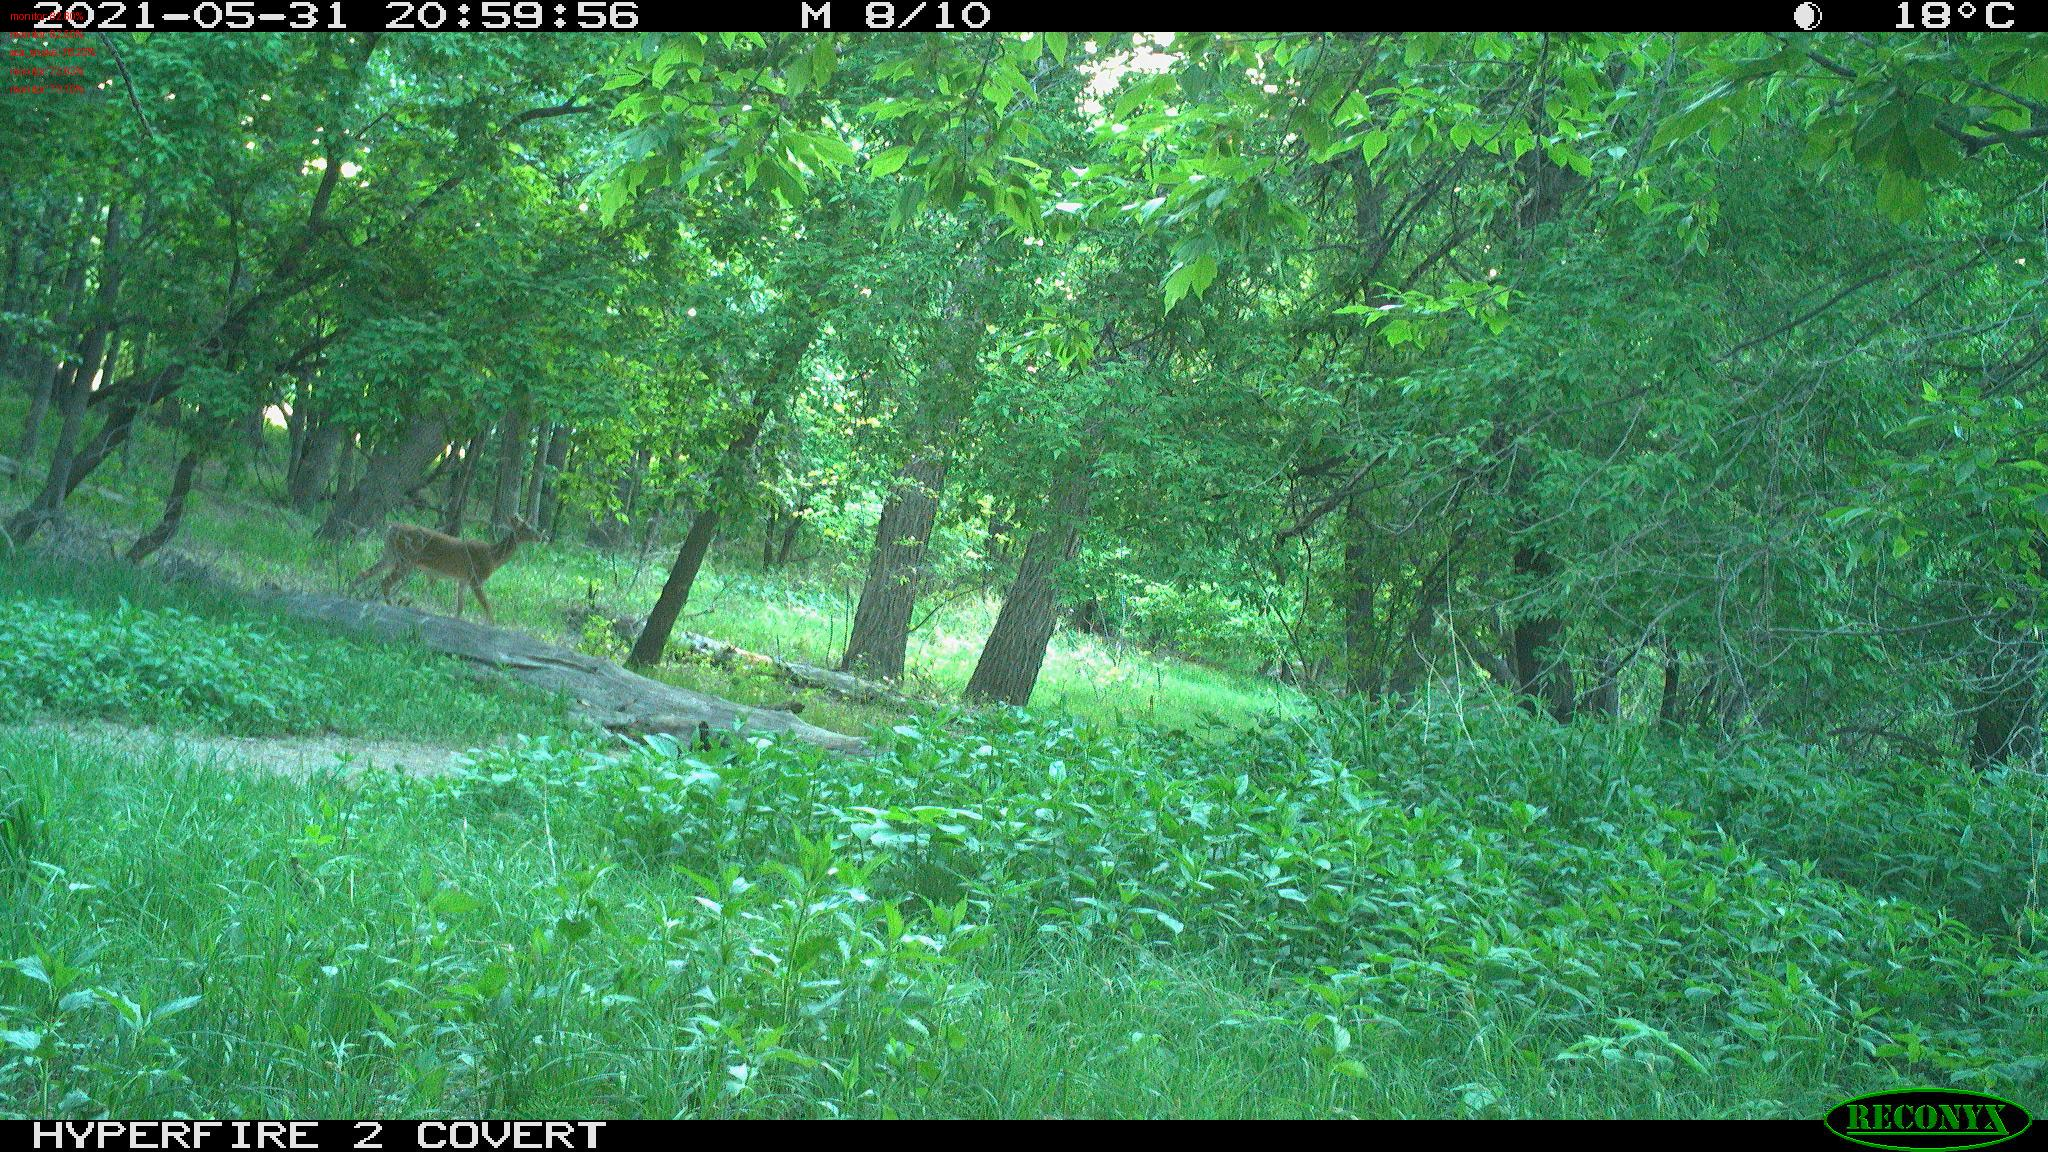

# Identifying 5 Objects in Multiple Images

This chapter extends the previous script to process a whole folder of images.
The code below adds a new function to process all images in a folder, and replaces the single-image code at the end. All other functions (model loading, prediction, sliding window, labeling) remain the same.


### Installing the Necessary Libraries

The following script performs the same actions as the script from the previous module but is capable of annotating several images rather than a single image.

Therefore the same modules will be used, with the addition of the `os` module. Importing this module will allow the script to read and write files more efficiently, which is critical when performing the object identification task on multiple images.

In [ ]:
# Import new modules
import os

### Save the Annotated Images & Process the Batch

This code block checks for the existence of an output directory, and uses the `os` module to create one if it doesn't exist already. This prevents errors further on in the code by ensuring that there is a designated place to save the newly annotated images. The process of loading, object identification, and annotating images stay the same.

In [ ]:
# New function: Process all images in a directory
def process_images_in_folder(folder_path, output_folder_path):
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                top_predictions = sliding_window_object_detection(img_path)
                img = Image.open(img_path)
                annotated_img = draw_labels(img, top_predictions)
                output_path = os.path.join(output_folder_path, f"annotated-{filename}")
                annotated_img.save(output_path)
                print(f"Processed {filename}. Top 5 identified objects with their confidence:")
                for obj, confidence in top_predictions:
                    print(f"{obj}: {confidence*100:.2f}%")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

The ‘for’ block reviews and processes all the files in the input folder path, and performs the `sliding_window_object_detection` function on all of the images it encounters. Like the script in the previous module, the top five most confidently identified objects are printed on the image along with their corresponding confidence scores in percent format.

The ‘except’ block ensures a graceful failure when processing any corrupted or unidentifiable images by printing an error message indicating which file was unable to be processed.

In this module, the `input_folder_path` and `output_folder_path` variables will be paths to actual folders, rather than images as it was in the previous module. This means that it is no longer necessary to attach the ‘annotated_image.jpg’ string to the end of the `output_folder_path`.

In [ ]:
# Set the path to your image folder and output folder
if image_dir:
    # Use images from Borealis dataset
    input_folder_path = image_dir
    output_folder_path = './annotated_images'
else:
    # Fallback paths if Borealis dataset not available
    input_folder_path = r'/content/drive/MyDrive/shared-data/Notebook datafiles/4370-entire-subset/id-resnet-images'
    output_folder_path = r'/content/drive/MyDrive/shared-data/Notebook datafiles/4370-entire-subset/id-resnet-list'

# Process all images in the specified folder
process_images_in_folder(input_folder_path, output_folder_path)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━

Sample image:

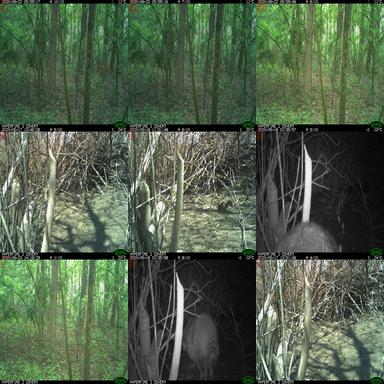

The images were assembled in grid format using the code from the 100-image grid Jupyter Notebook.

# Identifying Objects in Multiple Images Using Bounding Boxes

This chapter modifies the previous approach to:
- Draw bounding boxes around detected regions in each image.
- Output labeled images with boxes and labels.

All base logic, imported libraries, & model architecture remains unchanged, except for the following function modifications and usage.


## Module: Loading, Identifying, and Annotating the Images

The image loading, preprocessing, and object identification portions of the script will all remind the same.

The annotation portion of the script, however, must be altered to draw bounding boxes in addition to object labels. To do this the script must initialize the object ‘draw’ and load the default font for text drawing. Then the script loops through each object in the list and extracts the object name, confidence score, and bounding box coordinates.

In [ ]:
# New: sliding_window_object_detection now returns bounding box coordinates
def sliding_window_object_detection(img_path, window_size=(224, 224), step_size=112):
    img = Image.open(img_path)
    if img.getbands() != ('R', 'G', 'B'):
        img = img.convert('RGB')
    width, height = img.size
    detected_objects = []
    for top in range(0, height - window_size[1] + 1, step_size):
        for left in range(0, width - window_size[0] + 1, step_size):
            box = (left, top, left + window_size[0], top + window_size[1])
            cropped_img = img.crop(box)
            predictions = get_predictions(cropped_img)
            for _, obj, confidence in predictions:
                detected_objects.append((obj, confidence, box))
    detected_objects.sort(key=lambda x: x[1], reverse=True)
    return detected_objects[:5]

The line `draw.rectangle([left, top, right, bottom], outline=”red”, width=2)` determines the coordinates of the bounding box, the bounding box color, as well as the width of the rectangle in pixels. The bounding boxes being printed in this script are red and are 2 pixels wide.

The lines `draw.rectangle([text_background, (left + text_size[0], top)], fill=”red”)` and `draw.text((left, top - text_size[1]), text, fill=”white”, font=font)` creates a label with white text and a red background to ensure legibility.

In [ ]:
# New: draw_labels now draws bounding boxes and overlays label text
def draw_labels(img, objects):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    for obj, confidence, box in objects:
        left, top, right, bottom = box
        draw.rectangle([left, top, right, bottom], outline="red", width=2)
        text = f"{obj}: {confidence*100:.2f}%"
        try:
            # For newer Pillow versions
            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
        except AttributeError:
            # For older Pillow versions
            text_width, text_height = draw.textsize(text, font=font)
        text_background = (left, top - text_height)
        draw.rectangle([text_background, (left + text_width, top)], fill="red")
        draw.text((left, top - text_height), text, fill="white", font=font)

    return img

Sample Images:

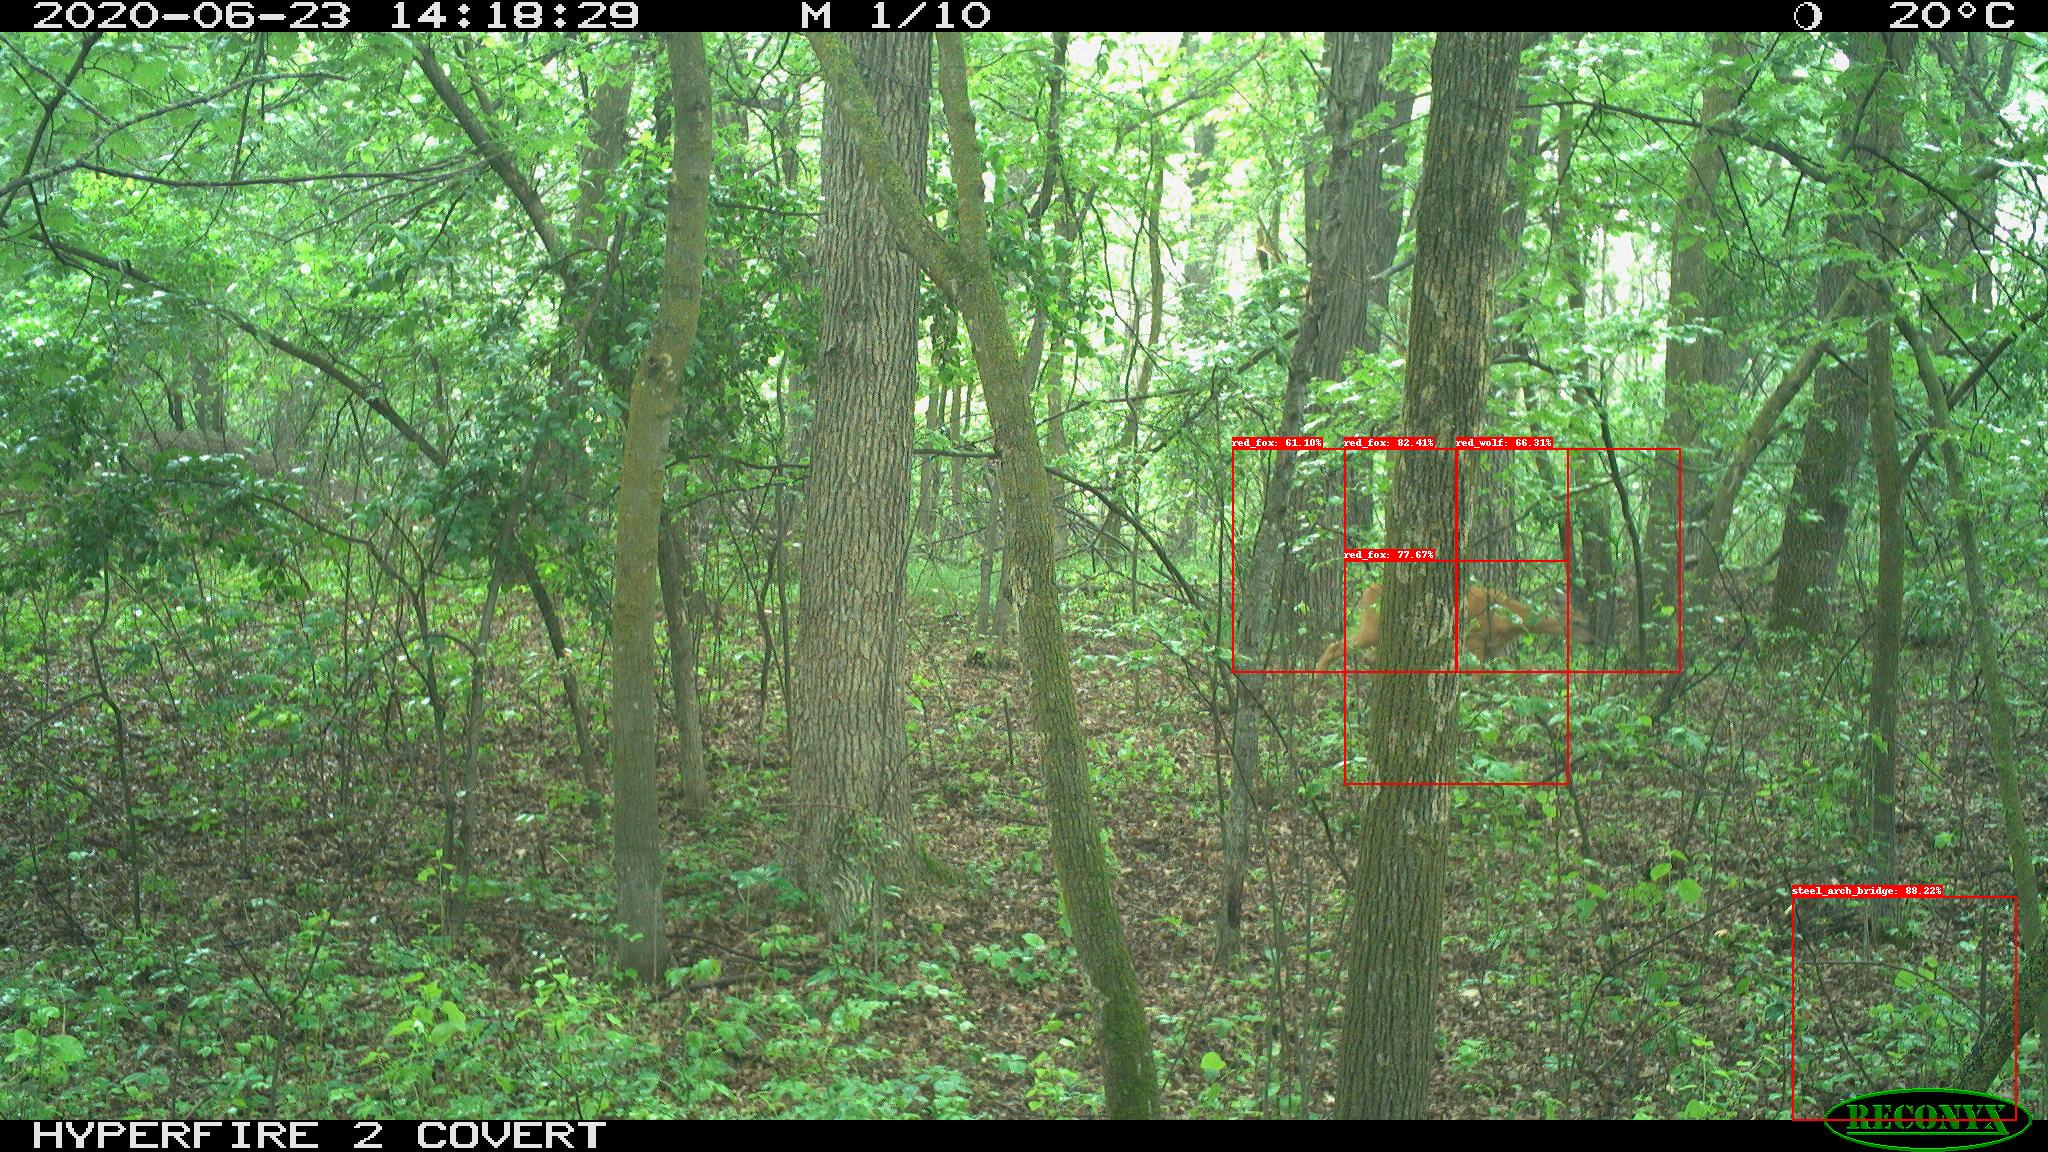

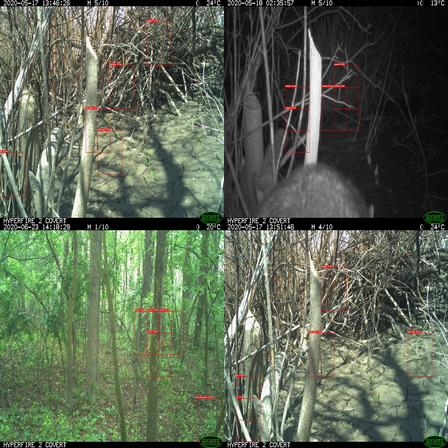

# Identifying Objects and Saving Them in an Excel File

This chapter adds functionality to store the detected objects, confidence scores, and bounding box coordinates for each processed image in an Excel file.


## Module: Installing the Necessary Libraries and Loading, Identifying, and Annotating the Images

In this module, the previous script will be modified to save an Excel file listing the identified objects. The script is still required to locate predicted objects using bounding boxes so the identification and annotation portions of the script will remain the same. However, the `pandas` library will need to be imported in addition to the previously used modules.

The `pandas` library is a data manipulation library that will aid in the creation of the Excel file.

In [ ]:
import pandas as pd  # Added for Excel output

## Module: Preparing Prediction Data

Like in the previous module, the following code block ensures that all images within a folder are processed and checks that an output directory for the annotated images exists. If it does not exist, the `os` module is used to create one.

However, the `results []` line initializes an empty list for the script to store the identified objects, which enables the data to be later exported to an Excel file.

In [ ]:
# Function to process all images in a directory and save results to an Excel file
def process_images_in_folder(folder_path, output_folder_path):
    # Ensure the output directory exists
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # List to store results
    results = []

    # Loop over all files in the directory
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                # Get top 5 predictions for the image
                top_predictions = sliding_window_object_detection(img_path)

                # Open the image
                img = Image.open(img_path)

                # Draw labels on the image
                annotated_img = draw_labels(img, top_predictions)

                # Save the annotated image
                output_path = os.path.join(output_folder_path, f"annotated-{filename}")
                annotated_img.save(output_path)

                # Save results to list
                for obj, confidence, box in top_predictions:
                    results.append({
                        "Filename": filename,
                        "Object": obj,
                        "Confidence": confidence * 100,
                        "Box": box
                    })

                # Print the top 5 predictions with their corresponding percentages
                print(f"Processed {filename}. Top 5 identified objects with their confidence:")
                for obj, confidence, _ in top_predictions:
                    print(f"{obj}: {confidence*100:.2f}%")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Create a DataFrame and save to an Excel file
    df = pd.DataFrame(results)
    excel_output_path = os.path.join(output_folder_path, "identified_objects.xlsx")
    df.to_excel(excel_output_path, index=False)
    print(f"Results saved to {excel_output_path}")

Here we use the same process as seen previously to use the `sliding_window_object_detection` function in order to identify objects within the provided images.

This code block iterates over the detected objects and creates a dictionary storing the filename, object name, confidence level, and bounding box coordinates. Each dictionary is appended to the `results` list created earlier in the script.

For each image processed a statement is printed, and an error statement has been incorporated for any corrupted or unidentifiable images.

## Module: Creating an Excel File Logging the Model Predictions

The pandas (imported as `pd`) library is used to convert the now-filled `results` list into a pandas DataFrame, a two-dimensional labeled data structure. The DataFrame is then exported to an Excel file in the specified directory. The `index=False` statement is crucial for maintaining clean data presentation as it prevents `pd` from writing row numbers in the Excel file.

A final print statement confirms the location of the saved Excel file.

In [ ]:
# Set the path to your image folder and output folder
if image_dir:
    # Use images from Borealis dataset
    input_folder_path = image_dir
    output_folder_path = './bounding_box_results'
else:
    # Fallback paths if Borealis dataset not available
    input_folder_path = '/content/drive/MyDrive/shared-data/Notebook datafiles/4370-entire-subset/id-resnet-images'
    output_folder_path = '/content/drive/MyDrive/shared-data/Notebook datafiles/4370-entire-subset/id-resnet-bound-box'

# Process all images in the specified folder
process_images_in_folder(input_folder_path, output_folder_path)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━

Sample Excel Result:

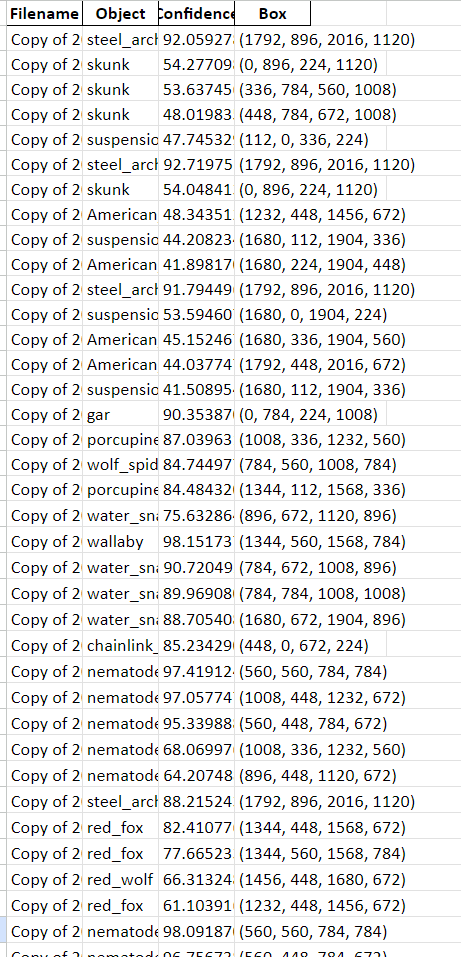